# RAG - Retrieval Augmented Gneration (검색 증강 생성)

## 전처리 단계

#### Load 
Document Loader - Excel/csv/pdf 등 로드할 수 있음. 
Document Loader의 종류가 매우 많으므로 선택시 고려할 수 있는 사항

1. 텍스트를 원형 그대로 잘 가져 오나?
	- 한글 인코딩 
	- 특수문자

2. 메타데이터의 종류는 어떤 것들이 있는가?
	- page_content: 문서 내용
	- 페이지 번호
	- 표, 차트, 문서의 coordinates(좌표), 속성(Title,Table,Image,Text)

UnstructuredFileLoader - 가장 많은 메타데이터 정보 제공 
- 요소별 Load 가능 
- mode="elements"
- 페이지 안의 세부 요소에 대한 정보가 필요하다면 좋은 Loader
- 속도가 다른 Loader에 비해 느림

PDFPlumber 
- 한글 인코딩 처리 능력이 우수하고 다양한 메타데이터 정보를 제공 
- 다양한 메타데이터 정보를 포함하고 있음.
- 읽기 속도가 가장 느림. (다량의 페이지를 포함하는 문서는 Parsing에 꽤 많은 시간이 소요)

#### Split 

Text Splitter

RecursiveCharacterTextSplitter 
- 범용적으로 많이 사용되는 분할 방식 
- chunk가 충분히 작아질 때까지 순서대로 분할하려고 시도
- 단락 -> 문장 -> 단어 순서로 함께 유지하려고 시도하는 효과가 있는데, 이는 일반적으로 텍스트의 가장 강력한 의미

오픈소스 
허깅페이스에 업로된 다양한 토크나이저를 쉽게 사용 가능 
신조어, 특정 도메인 용어(의료 용어)등의 tokenizer.trainer로 fine tuning 혹은 단순 추가 가능
- 대표적인 tokenizer 
	- Subword Tokenizer
	- BPE 
	- WordPiece
	- SentencePiece
	- spaCy
	- Moses

#### Embed 

Embedding

- 임베딩은 벡터 표현을 만든다. 
- 벡터 공간에서 가장 유사한 텍스트를 찾는 semantic search과 같은 작업을 수행할 수 있기 때문에 유용함.
- 따라서 문서에 적합한 임베딩 모델을 선택하는 것은 중요함. 한글도 고려 
- Langchain의 기본 임베딩 클래스는 두 가지 메서드를 제공
	- Document Embedding
	- Query Embedding 

`OpenAIEmbedding` 

`CacheBackedEmbeddings` : 임베딩을 저장하거나 임시로 캐싱하여 다시 계산할 필요가 없도록 함.
- 임베딩을 key-value 저장소에 캐싱
- 텍스트는 해시(hash)되고 해시는 캐시에서 키(key)로 사용 
- 여러 임베딩 모델을 사용하는 경우 namespace를 별도로 설정하여, 1개의 문서에 대한 서로 다른 캐싱이 가능 
- 캐싱된 임베딩 벡터를 가져오는 것은 매우 빠르게 조회가 가능함

### 예시 

- "foo가 뭐지?"라는 질문을 하면 우리는 그 질문을 prompt에 전달하지 또한 동시에 우리의 질문과 관련이 있는 문서들도 준비하게 된다.

- 저장된 vector나 검색기를 사용해서 foo를 포함하고 있는 문서를 찾아내는 방법은 추후에 나온다. 여기에서 단어 "foo"의 유무로 뭔가 검색을 하는 것이 아니라 vecctor space에서 검색하는 방법이나, 의미론적인 뜻이라거나, 그런걸 다 알아볼 것입니다. 

- 먼저 "foo"에 대해서 우리의 모델이 전혀 학습되어 있지 않다고 가정해봅시다. "foo"와 관련된 모든 문서를 가져와서 그 문서들을 context로써 우리의 질문과 함께 묶어서 큰 Language Model에 보냅니다. 모델은 기존에 학습된 수많은 데이터와 함께 더 나은 답변을 하도록 도와주기 위해 추가로 전송한 데이터까지 갖게 되었습니다. 이게 바로 RAG 입니다. 개인으로부터 제공된 데이터를 사용하거나 탐색함으로써 우리가 Language model의 능력을 더 확장시키는 것이죠. 

- 여기서 사용자가 원한다면 모델이 우리가 보낸 문서만을 가지고 답변하게 할 수 있습니다. 

- 순서 : 데이터 소스 -> Load -> Transform -> Embed -> Store -> Retrieve 

### Data Loaders & splitters

In [1]:
from langchain.chat_models import ChatOpenAI
from langchain.document_loaders  import UnstructuredFileLoader # PDF 호환
from langchain.text_splitter import CharacterTextSplitter

loader = UnstructuredFileLoader("document.txt")

splitter = CharacterTextSplitter(
    separator="\n", # 줄바꿈을 기준으로 문단을 나눈다.
    chunk_size = 600, 
    chunk_overlap = 100, # 문장이나 문단을 분할할 때 앞 조각 일부분을 가져오게 만든다. 문장이 그냥 잘려나가는걸 방지
)

docs = loader.load()

loader.load_and_split(text_splitter=splitter)

Created a chunk of size 717, which is longer than the specified 600
Created a chunk of size 608, which is longer than the specified 600
Created a chunk of size 642, which is longer than the specified 600
Created a chunk of size 1444, which is longer than the specified 600
Created a chunk of size 1251, which is longer than the specified 600
Created a chunk of size 1012, which is longer than the specified 600
Created a chunk of size 1493, which is longer than the specified 600
Created a chunk of size 819, which is longer than the specified 600
Created a chunk of size 1458, which is longer than the specified 600
Created a chunk of size 1411, which is longer than the specified 600
Created a chunk of size 742, which is longer than the specified 600
Created a chunk of size 669, which is longer than the specified 600
Created a chunk of size 906, which is longer than the specified 600
Created a chunk of size 703, which is longer than the specified 600
Created a chunk of size 1137, which is lon

[Document(page_content="Chapter 3\n'There are three stages in your reintegration,' said O'Brien. 'There is learning, there is understanding, and there is acceptance. It is time for you to enter upon the second stage.'", metadata={'source': 'document.txt'}),
 Document(page_content="As always, Winston was lying flat on his back. But of late his bonds were looser. They still held him to the bed, but he could move his knees a little and could turn his head from side to side and raise his arms from the elbow. The dial, also, had grown to be less of a terror. He could evade its pangs if he was quick-witted enough: it was chiefly when he showed stupidity that O'Brien pulled the lever. Sometimes they got through a whole session without use of the dial. He could not remember how many sessions there had been. The whole process seemed to stretch out over a long, indefinite time--weeks, possibly--and the intervals between the sessions might sometimes have been days, sometimes only an hour or two."

### Tiktoken

- LLM들은 Token을 같은 방법을 세어주지 않습니다. 토큰은 문자와 같은 의미가 아니기때문이죠. 

- Openai 사이트에서 Tokenizer의 예시를 확인하여 문장을 어떻게 토큰으로 반환하는지 볼 수 있습니다.

In [2]:
from langchain.chat_models import ChatOpenAI
from langchain.document_loaders  import UnstructuredFileLoader # PDF 호환
from langchain.text_splitter import CharacterTextSplitter

loader = UnstructuredFileLoader("document.txt")

splitter = CharacterTextSplitter.from_tiktoken_encoder(
    separator="\n", # 줄바꿈을 기준으로 문단을 나눈다.
    chunk_size = 600, 
    chunk_overlap = 100, # 문장이나 문단을 분할할 때 앞 조각 일부분을 가져오게 만든다. 문장이 그냥 잘려나가는걸 방지
)

docs = loader.load()

loader.load_and_split(text_splitter=splitter)

[Document(page_content='Chapter 3\n\'There are three stages in your reintegration,\' said O\'Brien. \'There is learning, there is understanding, and there is acceptance. It is time for you to enter upon the second stage.\'\nAs always, Winston was lying flat on his back. But of late his bonds were looser. They still held him to the bed, but he could move his knees a little and could turn his head from side to side and raise his arms from the elbow. The dial, also, had grown to be less of a terror. He could evade its pangs if he was quick-witted enough: it was chiefly when he showed stupidity that O\'Brien pulled the lever. Sometimes they got through a whole session without use of the dial. He could not remember how many sessions there had been. The whole process seemed to stretch out over a long, indefinite time--weeks, possibly--and the intervals between the sessions might sometimes have been days, sometimes only an hour or two.\n\'As you lie there,\' said O\'Brien, \'you have often wo

### Embeddings

- 임베딩은 사람이 읽는 텍스트를 컴퓨터가 이해할 수 있는 숫자들로 변환하는 작업

- 벡터화(vectorization) : 우리가 만든 문서마다 각각의 벡터를 만들어줄 것이다. 

- vector space : 일종의 데이터 베이스 개념입니다. 벡터 공간에서 검색을 할 수 있게 해줍니다. 

![Screenshot from 2024-03-30 14-49-49.png](<attachment:Screenshot from 2024-03-30 14-49-49.png>)
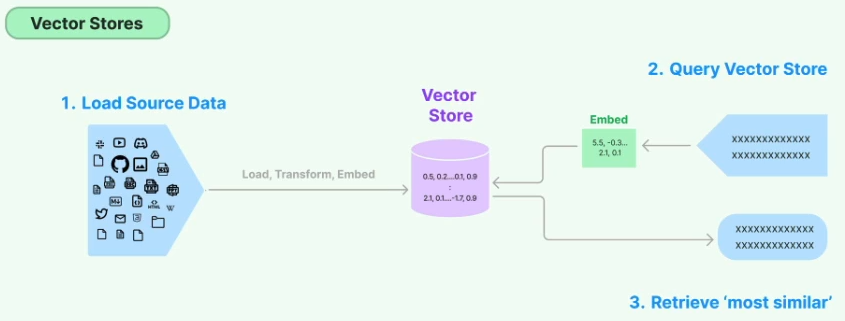

In [3]:
from langchain.embeddings import OpenAIEmbeddings

embedder = OpenAIEmbeddings()

vector = embedder.embed_query("Hi")

len(vector)

1536

In [4]:
from langchain.chat_models import ChatOpenAI
from langchain.document_loaders  import UnstructuredFileLoader # PDF 호환
from langchain.text_splitter import CharacterTextSplitter
from langchain.vectorstores import Chroma
from langchain.embeddings import OpenAIEmbeddings , CacheBackedEmbeddings
from langchain.storage import LocalFileStore

cache_dir = LocalFileStore("cache/") # 캐시 디렉토리 : 한번 실행한 결과를 저장해두자(비용 발생 방지)

loader = UnstructuredFileLoader("document.txt")

splitter = CharacterTextSplitter.from_tiktoken_encoder(
    separator="\n", # 줄바꿈을 기준으로 문단을 나눈다.
    chunk_size = 600, 
    chunk_overlap = 100, # 문장이나 문단을 분할할 때 앞 조각 일부분을 가져오게 만든다. 문장이 그냥 잘려나가는걸 방지
)

docs = loader.load_and_split(text_splitter=splitter)    

embeddings  = OpenAIEmbeddings()

cache_embeddings = CacheBackedEmbeddings.from_bytes_store(
    embeddings, cache_dir
) # embedding 작업을 위해 필요한 embedder의 입력을 요구합니다.

vectorstore = Chroma.from_documents(docs, cache_embeddings) # 실행할 때마다 비용발생함 ! 따라서 openaiembeddings 대신 미리 cache 되어있는 embeddings를 전달

In [5]:
result = vectorstore.similarity_search("Where does winston live?") # vector store를 통해 검색가능

len(result)

4

### RetrievalQA 

- off-the-shelf chain들을 사용해서 해보자!  

### RetrievalQA 

#### stuff documents

- 기본적으로 모든 document를 prompt에 채워 넣는 것을 의미함. 

- 'foo'가 무엇인가요? 라는 질문을 한다면 'foo'에 관한 document를 받고 모든 document들을 prompt에 삽입

- prompt를 보면 양이 매우 많은데 이는 모든 관련된 문서를 가져와서 그렇다 ! 

![Screenshot from 2024-03-30 15-35-04.png](<attachment:Screenshot from 2024-03-30 15-35-04.png>)


#### Refine documents chain 

- 'foo'는 무엇입니까? 라는 질문에 관련된 documents를 얻고 각각의 document를 읽으면서, 질문에 대한 답변 생성을 시도한다. 

- 'foo는 무엇입니까?'와 개별 document를 통해서. 

- 이 작업을 반복하면서 모든 document를 통해 question을 개선시킬 것이다. 

- 처음 답은 퀄리티가 낮지만 첫번째 document를 읽고 그것을 기반으로 답변을 업데이트한다. 두 번재 ~ 세번째 등 계속함. 

- 비용이 많이든다. chain 내부에서 계속 document에 질문을 던져야 하기 때문에. 

![Screenshot from 2024-03-30 15-37-14.png](<attachment:Screenshot from 2024-03-30 15-37-14.png>)


![Screenshot from 2024-03-30 15-40-54.png](<attachment:Screenshot from 2024-03-30 15-40-54.png>)


#### Map Reduce

- document들을 입력받아서 개별적으로 요약작업을 수행함. 그리고 각각의 요약본을 LLM에게 전달함.

- 굉장히 크고 많은 연산들이 수행된다. 

![Screenshot from 2024-03-30 15-40-34.png](<attachment:Screenshot from 2024-03-30 15-40-34.png>)

#### Map re-rank 

- 이 체인도 마찬가지로 질문에 관련된 documents를 모아서 각 document를 통해 답변을 생성하고, 각 답변에 점수를 매긴다. 

- 최종적으로는 가장 높은 점수를 획득한 답변과 그 점수를 함께 반환한다. 

![Screenshot from 2024-03-30 15-43-02.png](<attachment:Screenshot from 2024-03-30 15-43-02.png>)

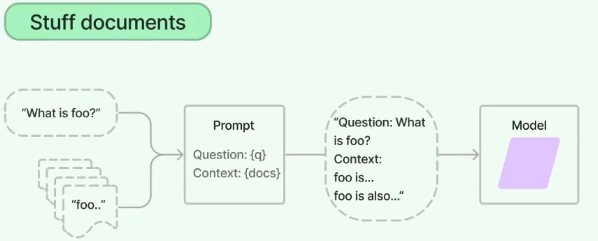
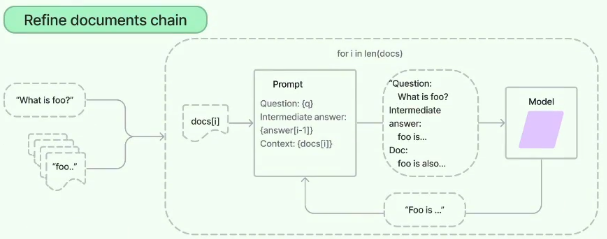
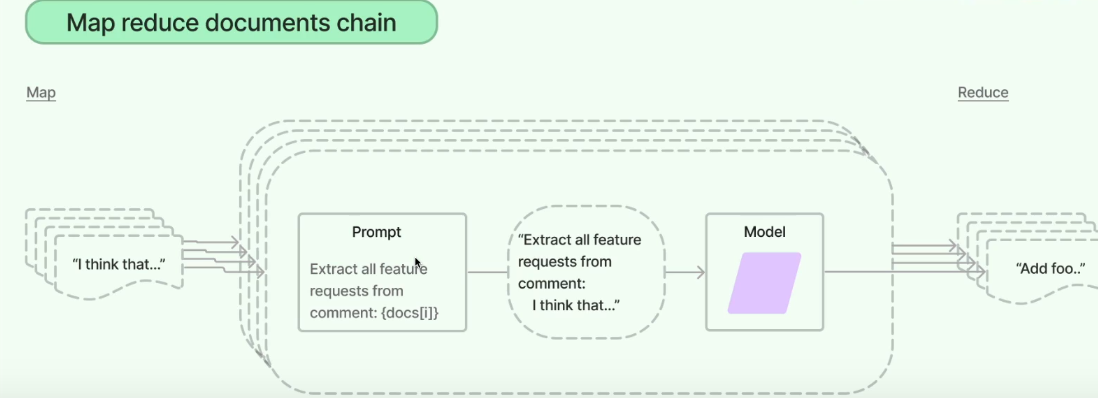
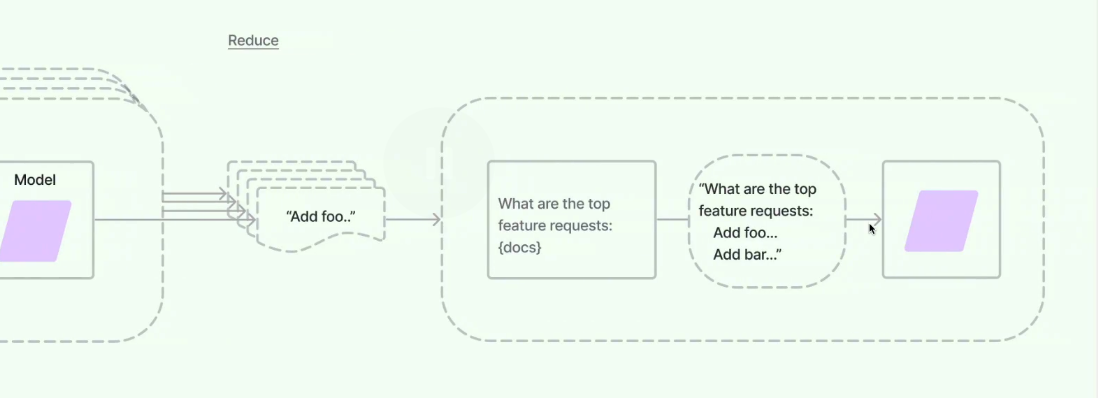
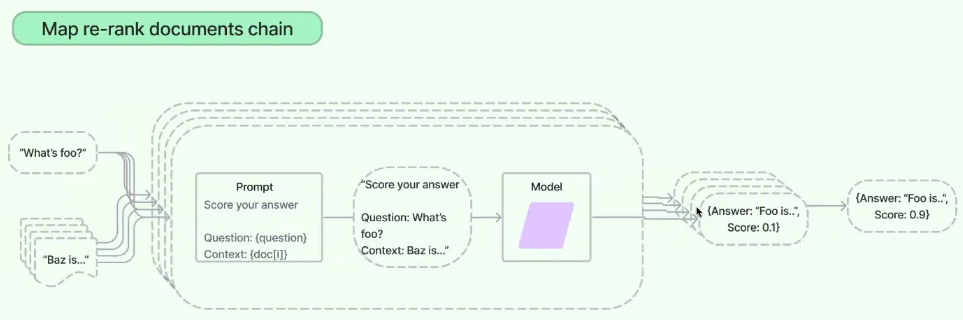

In [1]:
# RetrievalQA를 사용할때의 장점 중 하나가 chain_type을 손쉽게 바꿀 수 있다는 것임. 

from langchain.chat_models import ChatOpenAI
from langchain.document_loaders  import UnstructuredFileLoader # PDF 호환
from langchain.text_splitter import CharacterTextSplitter
from langchain.vectorstores import FAISS 
from langchain.embeddings import OpenAIEmbeddings , CacheBackedEmbeddings
from langchain.storage import LocalFileStore
from langchain.chains import RetrievalQA 

llm = ChatOpenAI()

cache_dir = LocalFileStore("cache/") # 캐시 디렉토리 : 한번 실행한 결과를 저장해두자(비용 발생 방지)

loader = UnstructuredFileLoader("document.txt") # document를 작게 분할하면 작업이 쉬워지고 응답도 빨라지고 LLM 사용 비용또한 훨씬 저렴해진다.

splitter = CharacterTextSplitter.from_tiktoken_encoder(
    separator="\n", # 줄바꿈을 기준으로 문단을 나눈다.
    chunk_size = 600, 
    chunk_overlap = 100, # 문장이나 문단을 분할할 때 앞 조각 일부분을 가져오게 만든다. 문장이 그냥 잘려나가는걸 방지
)

docs = loader.load_and_split(text_splitter=splitter)    

embeddings  = OpenAIEmbeddings()

cache_embeddings = CacheBackedEmbeddings.from_bytes_store(
    embeddings, cache_dir
) # embedding 작업을 위해 필요한 embedder의 입력을 요구합니다.

vectorstore = FAISS.from_documents(docs, cache_embeddings) # 실행할 때마다 비용발생함 ! 따라서 openaiembeddings 대신 미리 cache 되어있는 embeddings를 전달
# vectorstore를 FAISS로 변환 


chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type = "refine", # chain_type을 바꿀 수 있다. 
    retriever = vectorstore.as_retriever(), # retrieve는 document를 많은 장소로부터 Retrieve(선별하여 가져오기)할 수 있다
)

chain.run("describe victory mension")    

"The mention of victory in the context of the Party's control and manipulation, as described by O'Brien to Winston, takes on an even darker tone when considering the constant surveillance and propaganda that Winston is subjected to. Victory, in this oppressive society, is not just a distant achievement but a tool used by the Party to maintain its grip on power and instill fear in the population. The constant reminders of Big Brother watching, the consumption of Victory Gin as a means of numbing the mind, and the manipulation of information through the telescreen all contribute to a sense of perpetual oppression and control.\n\nO'Brien's description of victory as a state of perpetual power and domination becomes even more sinister when juxtaposed with Winston's fleeting moments of rebellion and resistance. The news of the war in Central Africa serves as a reminder of the Party's ability to manipulate and distort reality to serve its own interests. Victory, in this world, is not just a m

### Stuff LCEL Chain

- Langchain expression language(LCEL)를 사용해서 stuff chain을 구현해보자 

- Retriever는 하나의 string을 입력받는다. 그리고 Retriever의 출력값은 document들의 List이다. 

In [2]:
from langchain.chat_models import ChatOpenAI
from langchain.document_loaders  import UnstructuredFileLoader # PDF 호환
from langchain.text_splitter import CharacterTextSplitter
from langchain.vectorstores import Chroma
from langchain.embeddings import OpenAIEmbeddings , CacheBackedEmbeddings
from langchain.storage import LocalFileStore
from langchain.chains import RetrievalQA 
from langchain.prompts import ChatPromptTemplate
from langchain.schema.runnable import RunnablePassthrough

llm = ChatOpenAI(
    temperature = 0.1,
)

cache_dir = LocalFileStore("cache/") # 캐시 디렉토리 : 한번 실행한 결과를 저장해두자(비용 발생 방지)

loader = UnstructuredFileLoader("document.txt")

splitter = CharacterTextSplitter.from_tiktoken_encoder(
    separator="\n", # 줄바꿈을 기준으로 문단을 나눈다.
    chunk_size = 600, 
    chunk_overlap = 100, # 문장이나 문단을 분할할 때 앞 조각 일부분을 가져오게 만든다. 문장이 그냥 잘려나가는걸 방지
)

docs = loader.load_and_split(text_splitter=splitter)    

embeddings  = OpenAIEmbeddings()

cache_embeddings = CacheBackedEmbeddings.from_bytes_store(
    embeddings, cache_dir
) # embedding 작업을 위해 필요한 embedder의 입력을 요구합니다.

vectorstore = Chroma.from_documents(docs, cache_embeddings) # 실행할 때마다 비용발생함 ! 따라서 openaiembeddings 대신 미리 cache 되어있는 embeddings를 전달

retrieval = vectorstore.as_retriever()  

prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful assistanct. Answer questions using only the following context. If you don't know answer just say you don't know, don't make up anything : \n\n{context}"),
    ("human", "{question}")
])

# "describe victory mension" 이 값을 retriever에 전달하고, 그 결과로 출력된 document를 prompt의 context에 입력하고 또 이 질문을 prompt의 question property로 전달하는 것 까지야.
# RunnablePassthrough()는 "describe victory mension" 이 값을 말그대로 통과하게 해줄 것입니다. "question":"describe victory mension"  이렇게 되는거죠.

chain = {"context" : retrieval, "question": RunnablePassthrough(), "extra": RunnablePassthrough() }| prompt | llm 


chain.invoke("describe victory mension")    

AIMessage(content="The mention of victory in the document is associated with a trumpet-call that pierces the air, signaling a bulletin of victory. The news of victory is met with excitement and cheering, with phrases like 'vast strategic manoeuvre,' 'utter rout,' 'half a million prisoners,' and 'control of the whole of Africa' being mentioned. The atmosphere is filled with a sense of triumph and celebration, with the news of victory being described as the greatest victory in human history.")